In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")
sys.path.append("/home/gf332/miracle-compession/code/compression")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code/compression")
sys.path.append("/homes/gf332/miracle-compession/code")
sys.path.append("/homes/gf332/miracle-compession/code/compression")

import matplotlib.pyplot as plt
import numpy as np

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

from pipeline import clic_input_fn, create_model, optimizers, models
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data
from coding import ArithmeticCoder
from binary_io import write_bin_code, read_bin_code, to_bit_string, from_bit_string
from greedy_compression import code_grouped_greedy_sample, decode_grouped_greedy_sample

from two_stage_vae import ClicTwoStageVAE
from ladder_network import ClicNewLadderCNN

from compression import coded_sample, decode_sample

np.seterr(all="raise");

W0722 15:55:06.246586 139955761886976 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0722 15:55:06.250209 139955761886976 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/pipeline.py:20: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

W0722 15:55:06.273911 139955761886976 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0722 15:55:06.349358 139955761886976 deprecation_wrapper.py:

In [2]:
!ls /scratch/gf332/miracle-models

ladder_48_24_learn_log_gamma	     new_ladder_smaller_latent_space
ladder_48_24_learn_log_gamma_1_beta  new_ladder_small_latent_space
ladder_48_24_residual		     new_ladder_test
new_ladder_24_24_latent_space	     new_ladder_with_sigmoid_out
new_ladder_4_4_latent_space	     new_ladder_with_sigmoid_out_bigger_beta
new_ladder_48_24_latent_space	     two_stage_64_latents


In [4]:
model_key="ladder"
model_dir="/scratch/gf332/miracle-models/ladder_48_24_residual/"
config_path="/homes/gf332/miracle-compession/config/clic/ladder/ladder_48_24_residual.json"
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================


with open(config_path, "r") as cfg_file:
    config = json.load(cfg_file)

# ==========================================================================
# Create VAE model
# ==========================================================================

with tf.device("CPU:0"):
    vae = create_model(model_key, config, train_stage=1)

    optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Define Checkpoints
    # ==========================================================================

    global_step = tf.train.get_or_create_global_step()

    if isinstance(vae, tuple):
        trainable_vars = vae[0].get_all_variables() + vae[1].get_all_variables() + (global_step,)
        
    else:
        trainable_vars = vae.get_all_variables() + (global_step,)

    checkpoint_dir = os.path.join(model_dir, "checkpoints")

    checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
        variables=trainable_vars,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=config["checkpoint_name"])

Checkpoint found at /scratch/gf332/miracle-models/ladder_48_24_residual/checkpoints/_ckpt-33, restoring...
Model restored!


In [4]:
!ls /scratch/gf332/

datasets  miracle-models


In [7]:
vae[1].decode(vae[1].prior.sample())
vae[0].prior.sample()

TypeError: 'ClicNewLadderCNN' object does not support indexing

In [5]:
train_image_dir = "/scratch/gf332/datasets/miracle_image_compression/train/"
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

johns_image = "/homes/gf332/miracle-compession/img/poster/new_court.jpeg"
thong_vo_image = '/scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png'

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(thong_vo_image)
    
    im = tf.convert_to_tensor(train_img_1[None, ...])
    # two stage vae
    if isinstance(vae, tuple):
        z = vae[0].encode(im)
        z_mean = vae[0].posterior.loc
        z_ = vae[1](z_mean)
        encoded_1 = vae[0].decode(z_)
    
    else:
        encoded_1 = vae(im)
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    psnr = tf.image.psnr(tf.convert_to_tensor(train_img_1), encoded_1, max_val=1.0).numpy()[0]
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    print("PSNR: {:.4f}".format(psnr))
    
    if isinstance(vae, tuple):
        kld = tf.reduce_sum(vae[1].kl_divergence) / np.log(2)
        
    else:
        kld = sum([tf.reduce_sum(x) for x in vae.kl_divergence]) / np.log(2)
        
    print("KL divergence: {:.2f} bits, {:.2f} bytes".format(kld, kld / 8))

MS-SSIM: 0.9499
PSNR: 26.1224
KL divergence: 251222.62 bits, 31402.83 bytes


In [ ]:
if isinstance(vae, tuple):
    z_gen = vae[1].prior.sample()
    z_gen = vae[1].decode(z_gen)
    
    #z_gen = vae[0].prior.sample()
    im_gen = vae[0].decode(z_gen)
    
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im_gen))
plt.title("Generated", fontsize=18)
plt.axis("off")
plt.show()

In [6]:
244255.33 + 2 * np.log(244255.33 + 1)

244280.14194697127

In [7]:
244280/ 8

30535.0

In [8]:
with tf.device("CPU:0"):
    train_img_1 = load_and_process_image(thong_vo_image)
    print(train_img_1.shape.as_list())

[790, 1264, 3]


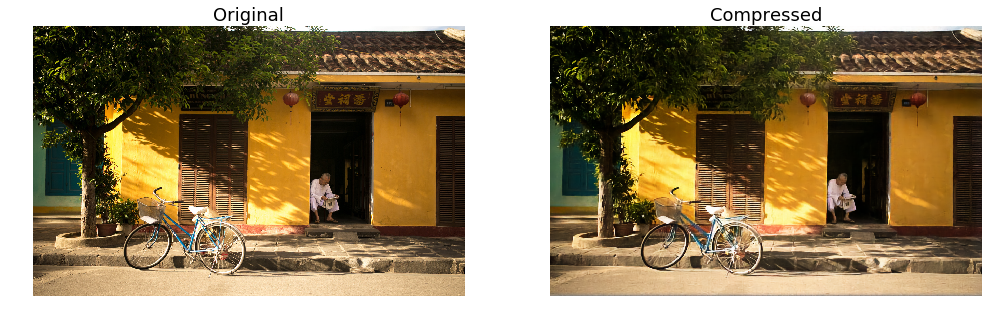

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [7]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/homes/gf332/miracle-compession/img/clic/thong_vo_residual_ladder.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

# Get results on the whole CLIC validation dataset

In [8]:
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

results = []

with tf.device("CPU:0"):
    for im_path in tqdm(valid_image_paths):

        image = tf.convert_to_tensor(load_and_process_image(valid_image_paths[0]))[None, ...]

        reconstruction = vae(image)
        reconstruction = tf.clip_by_value(reconstruction, 0., 1.)

        ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(image), reconstruction, 1.).numpy()[0]
        psnr = tf.image.psnr(image, reconstruction, max_val=1.0).numpy()[0]

        results.append((im_path, ms_ssim, psnr))

In [26]:
paths, ssims, psnrs = zip(*results)

ssim_mean = np.mean(ssims)
ssim_std = np.std(ssims)

psnrs_mean = np.mean(psnrs)
psnrs_std = np.std(psnrs)

print("MS-SSIM: {:.4f} \pm {:.4f}".format(ssim_mean, ssim_std))
print("PSNR: {:.2f} \pm {:.4f}".format(psnrs_mean, psnrs_std))

MS-SSIM: 0.9667 \pm 0.0001
PSNR: 32.49 \pm 0.0054


# Actual Compression bit, for real this time

In [9]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[4])
    im = tf.convert_to_tensor(train_img_1[None, ...])
    latents = vae.encode(im)
    
    res = vae.decode(latents)

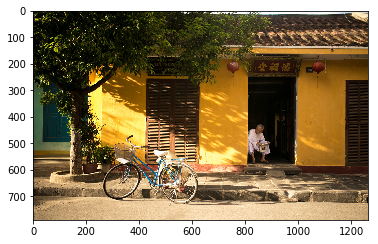

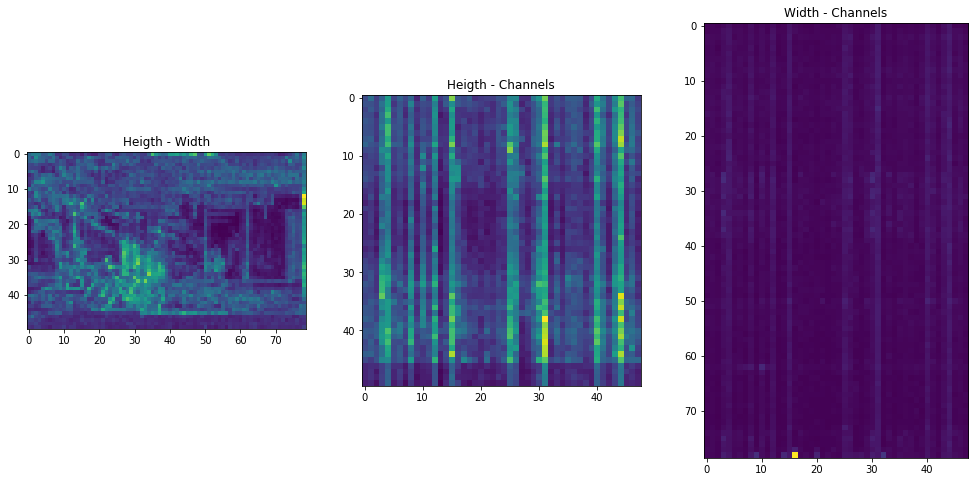

In [10]:
kl_1 = vae.kl_divergence[0][0]
kl_2 = vae.kl_divergence[1][0]

kl_1_hw = tf.reduce_sum(kl_1, axis=2)
kl_1_hc = tf.reduce_sum(kl_1, axis=1)
kl_1_wc = tf.reduce_sum(kl_1, axis=0)


plt.imshow(tf.squeeze(im))

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_1_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_1_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_1_wc, interpolation="nearest", aspect="equal", origin="upper")



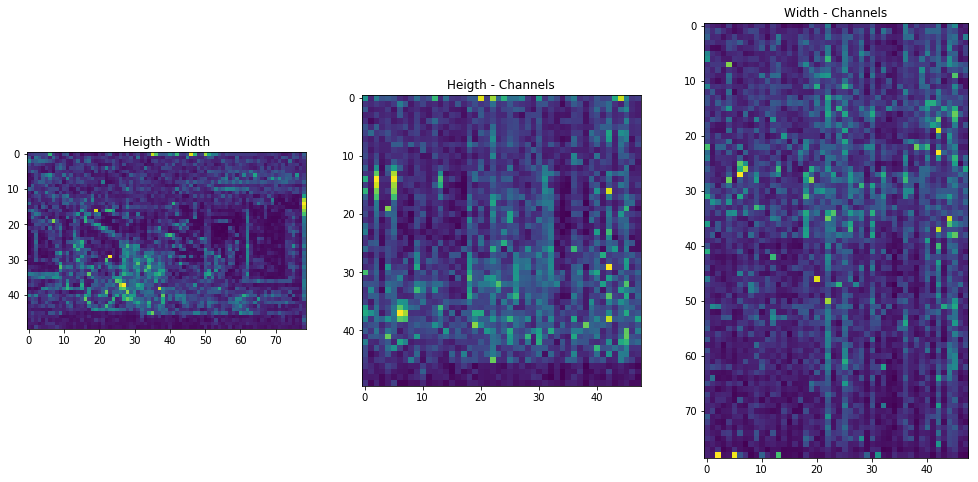

In [38]:
kl_1_hw = tf.reduce_max(kl_1, axis=2)
kl_1_hc = tf.reduce_max(kl_1, axis=1)
kl_1_wc = tf.reduce_max(kl_1, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_1_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_1_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_1_wc, interpolation="nearest", aspect="equal", origin="upper")

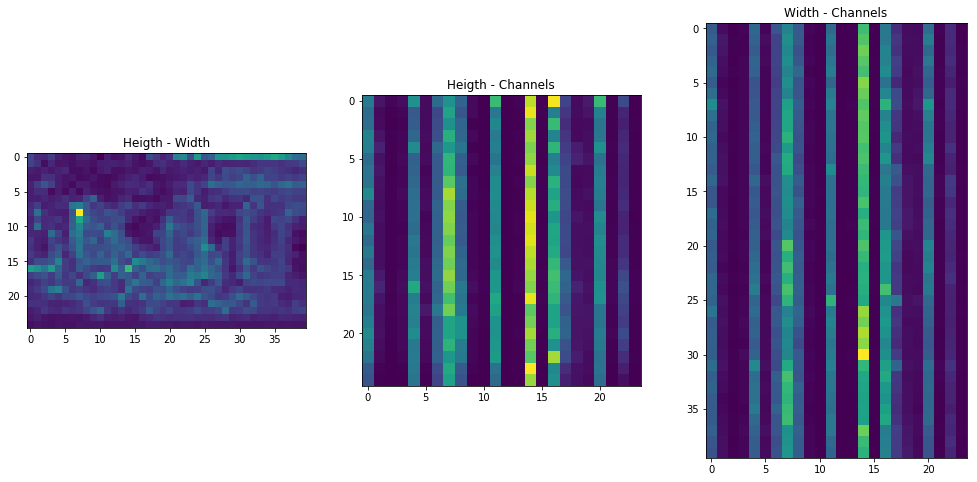

In [39]:
kl_2_hw = tf.reduce_sum(kl_2, axis=2)
kl_2_hc = tf.reduce_sum(kl_2, axis=1)
kl_2_wc = tf.reduce_sum(kl_2, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_2_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_2_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_2_wc, interpolation="nearest", aspect="equal", origin="upper")

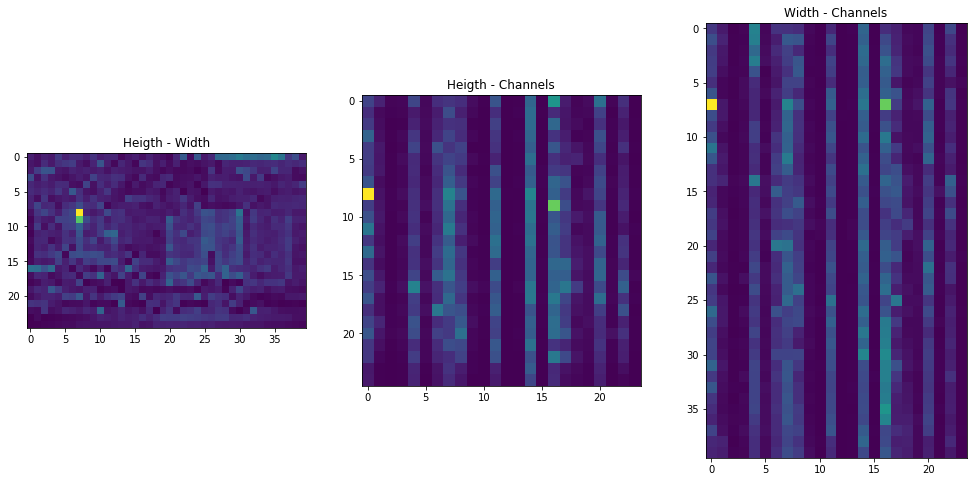

In [40]:
kl_2_hw = tf.reduce_max(kl_2, axis=2)
kl_2_hc = tf.reduce_max(kl_2, axis=1)
kl_2_wc = tf.reduce_max(kl_2, axis=0)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.title("Heigth - Width")
plt.imshow(kl_2_hw, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(132)
plt.title("Heigth - Channels")
plt.imshow(kl_2_hc, interpolation="nearest", aspect="equal", origin="upper")

plt.subplot(133)
plt.title("Width - Channels")
plt.imshow(kl_2_wc, interpolation="nearest", aspect="equal", origin="upper")

In [14]:
seed = 42
miracle_bits = 8

coded_samps = coded_sample(proposal=vae.latent_priors[1], 
                           target=vae.latent_posteriors[1], 
                           seed=seed, 
                           n_points=30, 
                           miracle_bits=miracle_bits,
                           outlier_mode="importance_sample")

100%|██████████| 256/256 [00:04<00:00, 52.25it/s]

Accepted 99.03% of samples, 639.0 latents not accepted.


In [6]:
from compression import rejection_sample

seed = 42
miracle_bits = 8

result = rejection_sample(p=vae.latent_priors[1],
                          q=vae.latent_posteriors[1],
                          n_points=30,
                          num_draws=2**miracle_bits,
                          calculate_importance_weights=True,
                          seed=seed)

W0708 14:52:00.457897 140506635159296 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/compression.py:34: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

W0708 14:52:00.932274 140506635159296 deprecation.py:323] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/tensorflow_probability/python/internal/special_math.py:251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 256/256 [00:01<00:00, 170.64it/s]


In [7]:
tf.reduce_max(result[3])

<tf.Tensor: id=26887, shape=(), dtype=float32, numpy=255.0>

In [10]:
decoded_samps = decode_sample(coded_sample=coded_samps,
                              proposal=vae.latent_priors[1], 
                              seed=seed, 
                              n_points=30, 
                              miracle_bits=miracle_bits, 
                              outlier_mode="quantize")

100%|██████████| 256/256 [00:00<00:00, 473.54it/s]


In [11]:
coded_samps_ = coded_sample(proposal=vae.latent_priors[0], 
                           target=vae.latent_posteriors[0], 
                           seed=seed, 
                           n_points=30, 
                           miracle_bits=miracle_bits)

100%|██████████| 256/256 [00:37<00:00,  7.01it/s]

Accepted 99.59% of samples, 2153.0 latents not accepted.


In [12]:
decoded_samps_ = decode_sample(coded_sample=coded_samps_,
                              proposal=vae.latent_priors[0], 
                              seed=seed, 
                              n_points=30, 
                              miracle_bits=miracle_bits, 
                              outlier_mode="quantize")

100%|██████████| 256/256 [00:00<00:00, 326.79it/s]


In [13]:
unique, _, counts = tf.unique_with_counts(coded_samps)


unique = unique.numpy()
counts = counts.numpy()

np.all((coded_samps < 256).numpy() == accepted.numpy())

NameError: name 'accepted' is not defined

<BarContainer object of 255 artists>

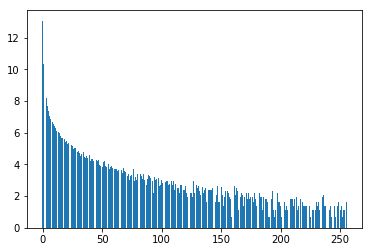

In [87]:
plt.bar(unique[unique < 256], np.log(counts[unique < 256]))

In [10]:
latent_shape_ = vae.latent_priors[0].loc.shape.as_list()
latent_shape = vae.latent_priors[1].loc.shape.as_list()
latent_shape_

[1, 86, 128, 64]

In [9]:
with tf.device("CPU:0"):
    decoded = vae.decode(latents)
#     decoded_ = tf.nn.sigmoid(vae.decode((tf.reshape(decoded_samps, latent_shape), 
#                                          tf.reshape(decoded_samps_, latent_shape_))))
    

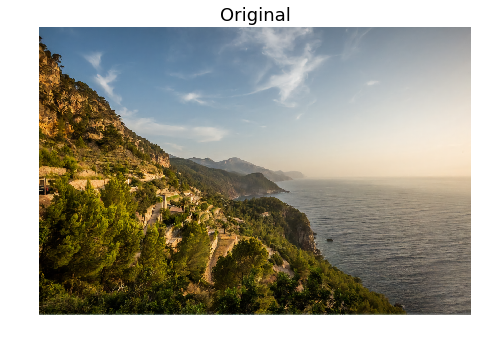

In [10]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(decoded).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

# plt.subplot(122)
# plt.title("Compressed", fontsize=18)
# plt.imshow(tf.squeeze(decoded_).numpy())
# plt.axis("off")

plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

prob_mass = np.load("../../probability_mass_48_24.npy")

total_mass = np.sum(prob_mass)

log_prob_mass = np.log(prob_mass)

log_total_mass = np.log(total_mass)

<BarContainer object of 256 artists>

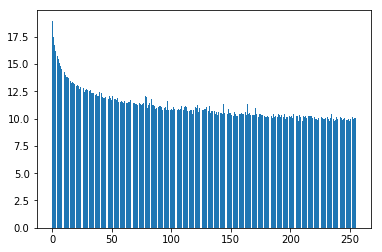

In [10]:
plt.bar(np.arange(len(prob_mass)), np.log(prob_mass))

In [20]:
log_prob_mass[0] - log_total_mass

-0.11732173697385306

In [12]:
100 * 2**16 / np.sum(prob_mass)

0.012697403590212564

In [7]:
num_bits = 2**16
gamma = 100

P = gamma * np.ones(num_bits)


In [7]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    for i, im_path in enumerate(valid_image_paths):
        
        im = load_and_process_image(im_path)
        print(i, im_path, im.shape)

0 /scratch/gf332/datasets/miracle_image_compression/valid/stefan-kunze-26931.png (1367, 2048, 3)
1 /scratch/gf332/datasets/miracle_image_compression/valid/sergey-zolkin-1045.png (1365, 2048, 3)
2 /scratch/gf332/datasets/miracle_image_compression/valid/wojciech-szaturski-3611.png (1325, 1988, 3)
3 /scratch/gf332/datasets/miracle_image_compression/valid/juskteez-vu-1041.png (1725, 1145, 3)
4 /scratch/gf332/datasets/miracle_image_compression/valid/thong-vo-428.png (790, 1264, 3)
5 /scratch/gf332/datasets/miracle_image_compression/valid/ales-krivec-15949.png (1188, 2048, 3)
6 /scratch/gf332/datasets/miracle_image_compression/valid/amy-zhang-15940.png (915, 1632, 3)
7 /scratch/gf332/datasets/miracle_image_compression/valid/todd-quackenbush-27493.png (1033, 2048, 3)
8 /scratch/gf332/datasets/miracle_image_compression/valid/alejandro-escamilla-6.png (1339, 2048, 3)
9 /scratch/gf332/datasets/miracle_image_compression/valid/sergey-zolkin-21232.png (1028, 1542, 3)
10 /scratch/gf332/datasets/mira

W0721 15:34:11.957932 139902008366848 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/compression.py:34: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.

W0721 15:34:11.967761 139902008366848 deprecation.py:323] From /homes/gf332/miracle-compession/miracle_venv/lib/python3.5/site-packages/tensorflow_probability/python/internal/special_math.py:251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 256/256 [00:04<00:00, 52.56it/s]


Accepted 97.39% of samples, 627.0 latents not accepted.


100%|██████████| 256/256 [00:18<00:00, 13.75it/s]


Accepted 98.88% of samples, 2132.0 latents not accepted.
Outlier / Miracle Mass Ratio: 0.0069


 10%|▉         | 20888/213601 [00:00<00:00, 208871.24it/s]

Depth of symbol tree: 17


100%|██████████| 213601/213601 [00:00<00:00, 327107.26it/s]


Expected code length: 492974.02 bits
Actual code length: 711211 bits
[42, 30, 50, 79, 25, 40]
Outlier / Miracle Mass Ratio: 0.0069
Depth of symbol tree: 17
Remaining bits at end of code: -3


100%|██████████| 256/256 [00:01<00:00, 163.74it/s]


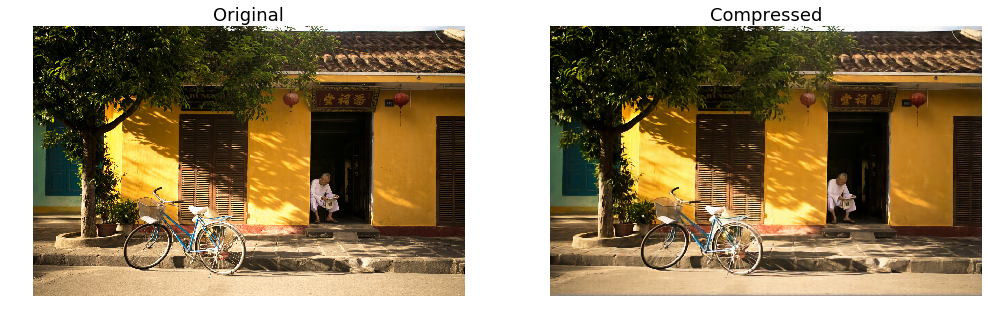

In [5]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

comp_file_path = "thong_vo_quant_bad.miracle"

seed = 42
miracle_bits = 8
outlier_mode = "quantize"
gamma=30

probability_mass = np.load("../../probability_mass_48_24.npy")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[4])
    im = tf.convert_to_tensor(im[None, ...])
    vae.code_image(image=im,
                   seed=seed,
                   gamma=gamma,
                   miracle_bits=miracle_bits,
                   probability_mass=probability_mass,
                   comp_file_path=comp_file_path,
                   outlier_mode=outlier_mode,
                   verbose=True)
    
    reconstruction = vae.decode_image(comp_file_path=comp_file_path,
                                      probability_mass=probability_mass,
                                      miracle_bits=miracle_bits,
                                      outlier_mode=outlier_mode,
                                      verbose=True)
    
    
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(reconstruction).numpy())
plt.axis("off")

plt.show()

In [8]:
1 / np.log(2)

1.4426950408889634

In [10]:
np.prod([790, 1264])

998560

In [12]:
(103 * 8 * 2**10) / (1.8 * 8 * 2**20)

0.05588107638888889

In [3]:
(86.2 * 8 * 2**10) / np.prod([790, 1264])

0.7071687229610639

In [14]:
244280 / np.prod([790, 1264])

0.24463227046947605

# Miguel's method

In [5]:
def code_greedy_sample(target, proposal, n_bits_per_step, n_steps, seed, rho=1., backfitting_steps=0):
    
    # Make sure the distributions have the correct type
    if target.dtype is not tf.float32:
        raise Exception("Target datatype must be float32!")
        
    if proposal.dtype is not tf.float32:
        raise Exception("Proposal datatype must be float32!")
        
    dim = len(proposal.loc)
    
    n_samples = int(2**n_bits_per_step)
    
    #print("Taking {} samples per step".format(n_samples))

    best_sample = tf.zeros((1, dim), dtype=tf.float32)
    sample_index = []
    
    # The scale divisor needs to be square rooted because
    # we are dealing with standard deviations and not variances
    scale_divisor = np.sqrt(n_steps)
    
    proposal_shard = tfd.Normal(loc=proposal.loc / n_steps,
                                scale=rho * proposal.scale / scale_divisor)

    for i in range(n_steps):

        # Set new seed
        tf.random.set_random_seed(1000 * seed + i)
        samples = proposal_shard.sample(n_samples)

        test_samples = tf.tile(best_sample, [n_samples, 1]) + samples

        log_probs = tf.reduce_sum(target.log_prob(test_samples), axis=1)

        index = tf.argmax(log_probs)

        best_sample = test_samples[index:index + 1, :]

        sample_index.append(index.numpy())
    
    # ----------------------------------------------------------------------
    # Perform backfitting
    # ----------------------------------------------------------------------
    
    for b in range(backfitting_steps):
        
        # Single backfitting step
        for i in range(n_steps):

            # Set seed to regenerate the previously generated samples here
            tf.random.set_random_seed(1000 * seed + i)
            samples = proposal_shard.sample(n_samples)
            
            idx = sample_index[i]
            # Undo the addition of the current sample
            best_sample = best_sample - samples[idx : idx + 1, :]
            
            # Generate candidate samples
            test_samples = tf.tile(best_sample, [n_samples, 1]) + samples

#             test_scores = tf.reduce_sum(-((test_samples - target.loc)**2 / target.scale**2)**4,
#                                        axis=1)

            test_scores = tf.reduce_sum(target.log_prob(test_samples), axis=1)
            index = tf.argmax(test_scores)

            best_sample = test_samples[index:index + 1, :]

            sample_index[i] = index.numpy()
    
    
    sample_index = list(map(lambda x: to_bit_string(x, n_bits_per_step), sample_index))
    sample_index = ''.join(sample_index)
    
    return best_sample, sample_index


def decode_greedy_sample(sample_index, proposal, n_bits_per_step, n_steps, seed, rho=1.):
    
    # Make sure the distributions have the correct type
    if proposal.dtype is not tf.float32:
        raise Exception("Proposal datatype must be float32!")
        
    dim = len(proposal.loc)
    
    indices = [from_bit_string(sample_index[i:i + n_bits_per_step]) 
               for i in range(0, n_bits_per_step * n_steps, n_bits_per_step)]
        
    # The scale divisor needs to be square rooted because
    # we are dealing with standard deviations and not variances
    scale_divisor = np.sqrt(n_steps)    
    
    proposal_shard = tfd.Normal(loc=proposal.loc / n_steps,
                                scale=rho * proposal.scale / scale_divisor)    
    
    n_samples = int(2**n_bits_per_step)
    
    sample = tf.zeros((1, dim), dtype=tf.float32)
        
    for i in range(n_steps):
        
        # Set new seed
        tf.random.set_random_seed(1000 * seed + i)
        
        samples = tf.tile(sample, [n_samples, 1]) + proposal_shard.sample(n_samples)

        index = indices[i]

        sample = samples[index:index + 1, :]
    
    return sample


def code_grouped_greedy_sample(target, 
                               proposal, 
                               n_bits_per_step, 
                               n_steps, 
                               seed, 
                               max_group_size_bits=12, # group size limited to 2^max_group_size_bits
                               adaptive=True,
                               backfitting_steps=0,
                               rho=1.):
    
    # Make sure the distributions have the correct type
    if target.dtype is not tf.float32:
        raise Exception("Target datatype must be float32!")
        
    if proposal.dtype is not tf.float32:
        raise Exception("Proposal datatype must be float32!")
    
    n_bits_per_group = n_bits_per_step * n_steps
    
    num_dimensions = np.prod(proposal.loc.shape.as_list())
    
    # ====================================================================== 
    # Preprocessing step: determine groups for sampling
    # ====================================================================== 
    if adaptive:
        
        group_start_indices = [0]
        group_kls = []
        
        kl_divs = tf.reshape(tfd.kl_divergence(target, proposal), [-1]).numpy()
        total_kl_bits = np.sum(kl_divs) / np.log(2)
        
        print("Total KL to split up: {:.2f} bits, "
              "maximum bits per group: {}, "
              "estimated number of groups: {},"
              "coding {} dimensions".format(total_kl_bits, 
                                            n_bits_per_group,
                                            total_kl_bits // n_bits_per_group + 1,
                                            num_dimensions
                                            ))
        
        current_group_size = 0
        current_group_kl = 0
        idx = -1
        prev_idx = -2
        twice_same = False
        
        while idx < num_dimensions - 1:
            
            if twice_same and idx == prev_idx:
                
                print("oh no: {}".format(idx))
                return
            
            twice_same = idx == prev_idx
            prev_idx = idx

            idx = idx + 1
            current_group_size = current_group_size + 1
            current_group_kl = current_group_kl + kl_divs[idx]
            
            #num_group_samps = np.ceil(np.exp(current_group_kl))
            
            if not ( np.log(current_group_size) / np.log(2) < max_group_size_bits and 
                     current_group_kl < n_bits_per_group * np.log(2) - 1):
                
                group_start_indices.append(idx)
                group_kls.append((current_group_kl - kl_divs[idx]) / np.log(2))
                
                current_group_size = 0
                current_group_kl = 0
                
                idx = idx - 1
                
            
            if idx == len(kl_divs) - 1:
                group_kls.append(current_group_kl / np.log(2))
    
    else:
        group_size = int(2**max_group_size_bits)
        
        group_start_indices = list(range(0, num_dimensions, group_size))
        
    # ====================================================================== 
    # Sample each group
    # ====================================================================== 
    
    results = []
    
    group_start_indices += [num_dimensions]
    
    # rescale proposal by the proposal
    p_loc = tf.reshape(tf.zeros_like(proposal.loc), [-1])
    p_scale = tf.reshape(tf.ones_like(proposal.scale), [-1])
    
    # rescale target by the proposal
    t_loc = (tf.reshape(target.loc, [-1]) - p_loc) / p_scale
    t_scale = tf.reshape(target.scale, [-1]) / p_scale
    
    for i in tqdm(range(len(group_start_indices) - 1)):
        
        start_idx = group_start_indices[i]
        end_idx = group_start_indices[i + 1]
        
        results.append(code_greedy_sample(
            target=tfd.Normal(loc=t_loc[start_idx:end_idx],
                              scale=t_scale[start_idx:end_idx]), 
            
            proposal=tfd.Normal(loc=p_loc[start_idx:end_idx],
                                scale=p_scale[start_idx:end_idx]), 
            
            n_bits_per_step=n_bits_per_step, 
            n_steps=n_steps, 
            seed=i + seed,
            backfitting_steps=backfitting_steps,
            rho=rho))
        
    samples, codes = zip(*results)
    
    bitcode = ''.join(codes)
    sample = tf.concat(samples, axis=1)
    
    return sample, bitcode, group_start_indices
        

def decode_grouped_greedy_sample(bitcode, 
                                 group_start_indices,
                                 proposal, 
                                 n_bits_per_step, 
                                 n_steps, 
                                 seed,
                                 adaptive=True,
                                 rho=1.):
    
    # Make sure the distributions have the correct type
    if proposal.dtype is not tf.float32:
        raise Exception("Proposal datatype must be float32!")
    
    n_bits_per_group = n_bits_per_step * n_steps
    
    num_dimensions = np.prod(proposal.loc.shape.as_list())
    
    # ====================================================================== 
    # Decode each group
    # ====================================================================== 
                
    samples = []
    
    group_start_indices += [num_dimensions]
    
    p_loc = tf.reshape(tf.zeros_like(proposal.loc), [-1])
    p_scale = tf.reshape(tf.ones_like(proposal.scale), [-1])
    
    for i in tqdm(range(len(group_start_indices) - 1)):
        
        samples.append(decode_greedy_sample(
            sample_index=bitcode[n_bits_per_group * i: n_bits_per_group * (i + 1)],
            
            proposal=tfd.Normal(loc=p_loc[group_start_indices[i]:group_start_indices[i + 1]],
                                scale=p_scale[group_start_indices[i]:group_start_indices[i + 1]]), 
            
            n_bits_per_step=n_bits_per_step, 
            n_steps=n_steps, 
            seed=i + seed,
            rho=rho))
        
    sample = tf.concat(samples, axis=1)
    
    # Rescale the sample
    sample = tf.reshape(proposal.scale, [-1]) * sample + tf.reshape(proposal.loc, [-1])
    
    return sample

In [181]:
tf.reduce_min(vae.latent_posteriors[1].scale)

<tf.Tensor: id=4315990, shape=(), dtype=float32, numpy=0.018076777>

In [6]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[22])
    latents = vae.encode(tf.convert_to_tensor(im[None, ...]))
    
    res = vae.decode(latents)

In [8]:
vae.latent_priors[0].loc.shape.as_list()

[1, 24, 32, 48]

In [81]:
kls = vae.kl_divergence[1].numpy()

avg_kl = np.mean(kls)
max_kl = np.max(kls)
quant_99_kl = np.percentile(kls, 99)

print("Average KL: {:.4f}".format(avg_kl))
print("Max KL: {:.4f}".format(max_kl))
print("99th percentile: {:.4f}".format(quant_99_kl))

Average KL: 1.2125
Max KL: 12.2014
99th percentile: 6.4851


In [14]:
n_bits_per_step = 14
n_steps = 30
seed = 2
rho = 1.

s1, c1, gi1 = code_grouped_greedy_sample(vae.latent_posteriors[1], 
                                         vae.latent_priors[1], 
                                         n_bits_per_step, 
                                         n_steps, 
                                         seed, 
                                         max_group_size_bits=6, # group size limited to 2^max_group_size_bits
                                         adaptive=True,
                                         backfitting_steps=2,
                                         rho=rho)

s1_ = decode_grouped_greedy_sample(c1,
                                   gi1,
                                   vae.latent_priors[1], 
                                   n_bits_per_step, 
                                   n_steps, 
                                   seed,
                                   adaptive=True,
                                   rho=rho)

Total KL to split up: 8060.68 bits, maximum bits per group: 420, estimated number of groups: 20.0,coding 4608 dimensions


In [15]:
s1_r = tf.cast(tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.float32)

print(s1_r.shape.as_list())
print(vae.latent_posteriors[1].sample().shape.as_list())

second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(s1_r))
average_sample_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(vae.latent_posteriors[1].sample()))

print("Avg greedy sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))
print("Avg sample log likelihood on level 2: {:.4f}".format(average_sample_lik))

[1, 12, 16, 24]
[1, 12, 16, 24]
Avg greedy sample log likelihood on level 2: -0.5346
Avg sample log likelihood on level 2: -0.2287


In [16]:
kl_divs = tf.reshape(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]), [-1]).numpy()
total_kl_bits = np.sum(kl_divs) / np.log(2)
total_kl_bits

23318.743468025477

In [17]:
np.all(s1_.numpy() == s1.numpy())

False

In [18]:
r = vae.decode((tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.zeros_like(latents[1])))
#vae.decode(latents)
kl_divs = tf.reshape(tfd.kl_divergence(vae.latent_posteriors[0], vae.latent_priors[0]), [-1]).numpy()
total_kl_bits = np.sum(kl_divs) / np.log(2)
total_kl_bits

28562.014306264413

In [19]:
s2, c2, gi2 = code_grouped_greedy_sample(vae.latent_posteriors[0], 
                                         vae.latent_priors[0], 
                                         n_bits_per_step, 
                                         n_steps, 
                                         seed, 
                                         max_group_size_bits=12, # group size limited to 2^max_group_size_bits
                                         backfitting_steps=0,
                                         adaptive=True)

Total KL to split up: 28562.01 bits, maximum bits per group: 420, estimated number of groups: 69.0,coding 36864 dimensions


In [20]:
s2_ = decode_grouped_greedy_sample(c2,
                                   gi2,
                                   vae.latent_priors[0], 
                                   n_bits_per_step, 
                                   n_steps, 
                                   seed, 
                                   adaptive=True,
                                   rho=rho)

In [21]:
s2

<tf.Tensor: id=898092, shape=(1, 36864), dtype=float32, numpy=
array([[ 0.17836897, -1.2995651 ,  0.03478041, ..., -1.6019754 ,
         0.29680645, -0.8576181 ]], dtype=float32)>

In [22]:
s2_

<tf.Tensor: id=964678, shape=(1, 36864), dtype=float32, numpy=
array([[ 0.2587579 , -0.85043055, -0.0019007 , ..., -0.7681295 ,
        -0.13896473, -0.49003047]], dtype=float32)>

In [23]:
s2_r = tf.cast(tf.reshape(s2_, vae.latent_priors[0].loc.shape.as_list()), tf.float32)
s1_r = tf.cast(tf.reshape(s1_, vae.latent_priors[1].loc.shape.as_list()), tf.float32)

print(s2_r.shape.as_list())
print(s1_r.shape.as_list())
print(vae.latent_posteriors[0].sample().shape.as_list())
print(vae.latent_posteriors[1].sample().shape.as_list())

r= vae(tf.convert_to_tensor(im[None, ...]))

first_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[0].log_prob(s2_r))
second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(s1_r))
first_sample_avg = tf.reduce_mean(vae.latent_posteriors[0].log_prob(vae.latent_posteriors[0].sample()))

print("Avg greedy sample log likelihood on level 1: {:.4f}".format(first_avg_log_lik))
print("Avg sample log likelihood on level 1: {:.4f}".format(first_sample_avg))
print("Avg greedy sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))

[1, 24, 32, 48]
[1, 12, 16, 24]
[1, 24, 32, 48]
[1, 12, 16, 24]
Avg greedy sample log likelihood on level 1: -2.0062
Avg sample log likelihood on level 1: -0.0328
Avg greedy sample log likelihood on level 2: -0.5346


In [24]:
np.save("lily-vae-level-1-prior-mean.npy", vae.latent_priors[0].loc)
np.save("lily-vae-level-1-prior-scale.npy", vae.latent_priors[0].scale)
np.save("lily-vae-level-1-posterior-mean.npy", vae.latent_posteriors[0].loc)
np.save("lily-vae-level-1-posterior-scale.npy", vae.latent_posteriors[0].scale)

np.save("lily-vae-level-2-prior-mean.npy", vae.latent_priors[1].loc)
np.save("lily-vae-level-2-prior-scale.npy", vae.latent_priors[1].scale)
np.save("lily-vae-level-2-posterior-mean.npy", vae.latent_posteriors[1].loc)
np.save("lily-vae-level-2-posterior-scale.npy", vae.latent_posteriors[1].scale)

np.save("lily-vae-level-2-sample.npy", s1_r)
np.save("lily-vae-level-1-sample.npy", s2_r)

In [213]:
np.percentile(vae.latent_posteriors[0].scale.numpy(), 0)

0.08483561128377914

In [212]:
np.percentile(vae.latent_priors[0].scale.numpy(), 10)

0.20551083683967591

In [221]:
np.percentile(vae.latent_posteriors[0].log_prob(s2_r.numpy()), 40)

-2.780556869506836

In [232]:
np.percentile(vae.latent_posteriors[0].log_prob(vae.latent_posteriors[0].sample()), 35)

-0.1140116408467293

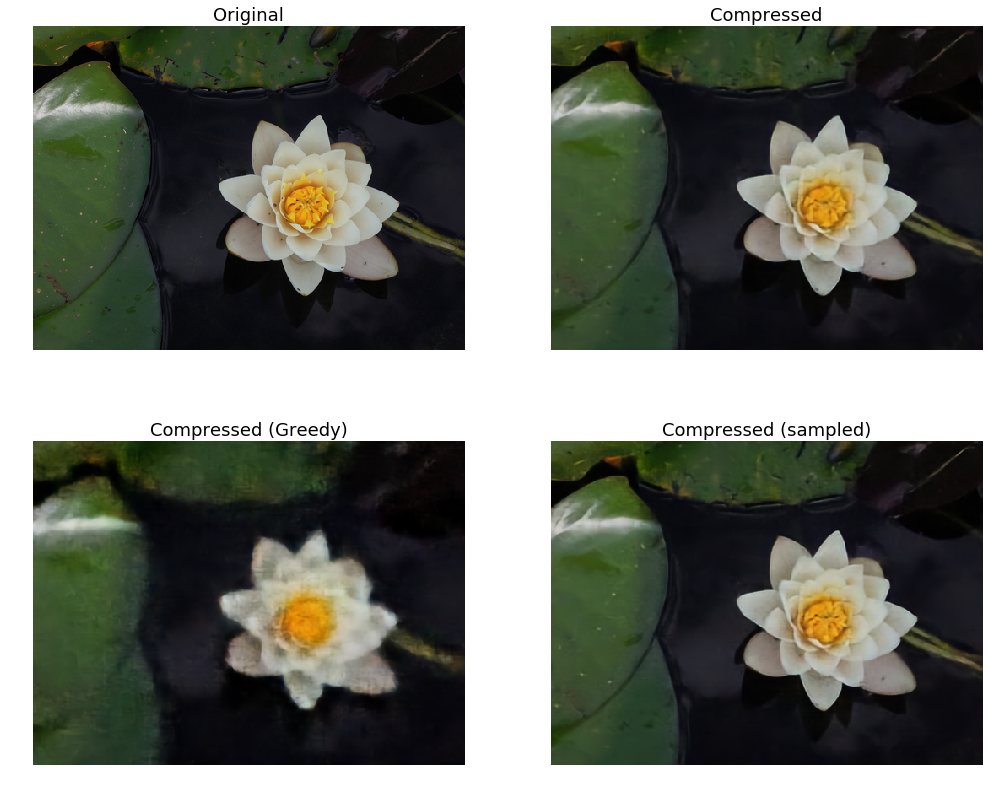

In [193]:
reconstruction = vae.decode((s1_r, s2_r))
mean_reconstruction = vae.decode((vae.latent_posteriors[1].loc, vae.latent_posteriors[0].sample()))

plt.figure(figsize=(17, 14))
plt.subplot(221)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(222)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(res).numpy())
plt.axis("off")

plt.subplot(223)
plt.title("Compressed (Greedy)", fontsize=18)
plt.imshow(tf.squeeze(reconstruction).numpy())
plt.axis("off")

plt.subplot(224)
plt.title("Compressed (sampled)", fontsize=18)
plt.imshow(tf.squeeze(mean_reconstruction).numpy())
plt.axis("off")

plt.savefig("compression_comparison.png")

plt.show()

In [30]:
vae.latent_posteriors

(<tfp.distributions.Normal 'new_clic_ladder_cnn_1/encode/Normal/' batch_shape=[1, 24, 32, 48] event_shape=[] dtype=float32>,
 <tfp.distributions.Normal 'new_clic_ladder_cnn_1/encode/Normal/' batch_shape=[1, 12, 16, 24] event_shape=[] dtype=float32>)

In [62]:
write_bin_code(c1 + c2, "miguel.miracle")

In [66]:
vae(tf.convert_to_tensor(train_img_1[None, ...]))
total_kl = sum([tf.reduce_sum(x) for x in vae.kl_divergence])

theoretical_byte_size = (total_kl + 2 * np.log(total_kl + 1)) / np.log(2) / 8
actual = os.path.getsize("miguel.miracle") + (len(gi1) + len(gi2)) * 3

print("Theoretical size: {:.2f} bytes".format(theoretical_byte_size))
print("Actual size: {:.2f} bytes".format(actual))
print("Efficiency: {:.3f}".format(actual / theoretical_byte_size))

Theoretical size: 29858.03 bytes
Actual size: 31583.00 bytes
Efficiency: 1.058


In [ ]:
train_img_1.shape

# Miguel's Method, as it's supposed to be used

In [5]:
valid_image_dir = "/scratch/gf332/datasets/miracle_image_compression/valid"
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

comp_file_path = "lily_miguel.miracle"

n_bits_per_step = 4
n_steps = 100
seed = 1
rho = 1.

with tf.device("CPU:0"):
    
    im = load_and_process_image(valid_image_paths[22])
    im = tf.convert_to_tensor(im[None, ...])
    
    res1 = vae.code_image_greedy(image=im,
                          seed=seed,
                          rho=rho,
                          n_steps=n_steps,
                          n_bits_per_step=n_bits_per_step,
                          comp_file_path=comp_file_path,
                          verbose=True)
    
    res2 = vae.decode_image_greedy(comp_file_path=comp_file_path,
                                             verbose=True,
                                             rho=rho)

  0%|          | 0/18 [00:00<?, ?it/s]W0720 01:18:38.995898 139625041262336 deprecation_wrapper.py:119] From /homes/gf332/miracle-compession/code/clic/greedy_compression.py:55: The name tf.random.set_random_seed is deprecated. Please use tf.compat.v1.random.set_random_seed instead.



Coding second level
Total KL to split up: 6999.75 bits, maximum bits per group: 400, estimated number of groups: 18.0,coding 4608 dimensions


  0%|          | 0/148 [00:00<?, ?it/s]

Coding first level
Total KL to split up: 57885.57 bits, maximum bits per group: 400, estimated number of groups: 145.0,coding 36864 dimensions


  5%|▌         | 1/19 [00:00<00:02,  7.48it/s]

Decoding second level


  1%|          | 1/149 [00:00<00:20,  7.27it/s]

Decoding first level


100%|██████████| 149/149 [00:19<00:00,  6.99it/s]


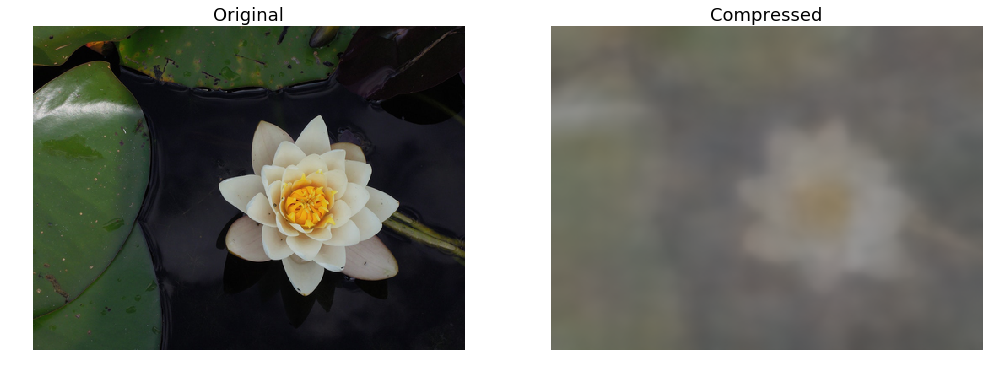

In [27]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(tf.squeeze(im).numpy())
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(reconstruction.numpy())
plt.axis("off")

plt.show()

In [6]:
len(code_)

33000

In [7]:
code[:25000] == code_[:25000]

True

In [8]:
code[25000:] == code_[25000:]

True

In [30]:
samp1, samp2 = samps

In [31]:
samp2_r = tf.cast(tf.reshape(samp2, vae.latent_priors[1].loc.shape.as_list()), tf.float32)
samp1_r = tf.cast(tf.reshape(samp1, vae.latent_priors[0].loc.shape.as_list()), tf.float32)

In [21]:
tf.reduce_sum(tf.abs(s2 - samp1))

<tf.Tensor: id=1336752, shape=(), dtype=float32, numpy=3987.4004>

In [23]:
first_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[0].log_prob(samp1_r))
second_avg_log_lik = tf.reduce_mean(vae.latent_posteriors[1].log_prob(samp2_r))

print("Avg sample log likelihood on level 1: {:.4f}".format(first_avg_log_lik))
print("Avg sample log likelihood on level 2: {:.4f}".format(second_avg_log_lik))

Avg sample log likelihood on level 1: -0.7370
Avg sample log likelihood on level 2: -43.2037


In [32]:
rec = vae.decode((samp2_r, samp1_r))

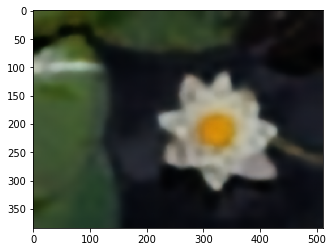

In [33]:
plt.imshow(tf.squeeze(rec).numpy())

In [6]:
sample1, sample2, code1, code2, gi1, gi2 = res1
rec, code1_, code2_, sample2_, sample1_, gi1_, gi2_ = res2

In [7]:
code1 == code1_

True

In [8]:
code2 == code2_

True

In [9]:
sample1

<tf.Tensor: id=837300, shape=(1, 36864), dtype=float32, numpy=
array([[-0.8544838 , -0.851691  , -0.21831572, ..., -1.7337468 ,
        -2.0444329 , -1.4967952 ]], dtype=float32)>

In [10]:
tf.reshape(sample1_, [1, -1])

<tf.Tensor: id=1361419, shape=(1, 36864), dtype=float32, numpy=
array([[-0.30463812, -0.8748013 ,  0.20261963, ..., -0.79765815,
        -3.069958  , -1.4663751 ]], dtype=float32)>

In [11]:
np.all(np.array(gi1) == np.array(gi1_[:-1]))

True

In [12]:
np.all(np.array(gi2) == np.array(gi2_[:-1]))

True

In [25]:
vae(im)

decoded_first_level = decode_grouped_greedy_sample(bitcode=code1, 
                                                    group_start_indices=gi1,
                                                    proposal=vae.latent_priors[0], 
                                                    n_bits_per_step=n_bits_per_step, 
                                                    n_steps=n_steps, 
                                                    seed=seed,
                                                    rho=rho, 
                                                    max_group_size_bits=12,
                                                    adaptive=True)

100%|██████████| 66/66 [00:09<00:00,  7.88it/s]


In [26]:
decoded_first_level

<tf.Tensor: id=1481602, shape=(1, 36864), dtype=float32, numpy=
array([[ 0.13177909, -0.33158055, -0.241965  , ...,  0.12075581,
        -2.0340698 , -0.7885769 ]], dtype=float32)>

In [27]:
sample1

<tf.Tensor: id=409952, shape=(1, 36864), dtype=float32, numpy=
array([[ 0.05924196, -0.3959521 , -0.24317046, ...,  0.12700252,
        -2.317717  , -1.2618713 ]], dtype=float32)>

In [20]:
sample1_

<tf.Tensor: id=668895, shape=(1, 24, 32, 48), dtype=float32, numpy=
array([[[[ 0.09686321, -0.27634954, -0.10679542, ...,  0.06754019,
           0.08991182,  0.04332251],
         [-0.06483328, -0.18831588, -0.11120194, ..., -0.04142552,
          -0.02328083,  0.17116971],
         [ 0.16711658, -0.27890134, -0.21565613, ...,  0.13675241,
          -0.05544113,  0.06803259],
         ...,
         [-0.02990704, -0.2648424 , -0.11019287, ...,  0.2149659 ,
          -0.40865958, -0.09036217],
         [-0.04278073, -0.33185375,  0.0459677 , ...,  0.0841442 ,
          -0.2453352 ,  0.09045904],
         [ 0.20401777, -0.10124908, -0.02237328, ...,  0.13889053,
          -0.39888215, -0.296526  ]],

        [[-0.02709026, -0.21353735, -0.20771438, ...,  0.17404509,
          -0.22284858, -0.16034658],
         [-0.0378814 , -0.33324617, -0.18315813, ...,  0.00278103,
          -0.09216564,  0.00703852],
         [ 0.13055952, -0.3320116 , -0.12971778, ...,  0.08843052,
          -0.1374

In [28]:
tf.ones((3,3)) / (2 * tf.ones((3,3)))

<tf.Tensor: id=1481613, shape=(3, 3), dtype=float32, numpy=
array([[0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]], dtype=float32)>